### Preliminars

##### Imports

In [1]:
# Own modules
import preprocess
import sample
import cluster
import nn
import k_means
import fuzzy_c_means
import mountain
import regression
import visualize
import index
import SVM
import d_tree

# Pip modules
import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
import os
import sys

# Interactive plots
%matplotlib widget
# Reload code after saving
%reload_ext autoreload
%autoreload 2

# Setting a random seed to test reliably
np.random.seed(420)

# Turns off printing from any function
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Paths to save media to
image = "../images/"
table = "../tables/"


##### Read Data

In [3]:
# Choose dataset to work with
dataset = 0
if dataset == 0:
    csv_file = "../data/pulsar_data_train.csv"
    csv_index, csv_header = None, 0
    csv_out = -1
    classify = True
else:
    csv_file = '../data/examen.csv'
    csv_index, csv_header = None, None
    csv_out = -1
    classify = False

# Read data from the specified file
data, N_S, I_S = preprocess.get_data(csv_file, csv_header, csv_index)
# Splits inputs and outputs and normalizes them
X_S, Y_S, X_name, Y_name = preprocess.split_XY(data, csv_out)
X_S, Y_S, X_revert, Y_revert = preprocess.preprocess(X_S.T, Y_S.T, classify)


### Data Distribution

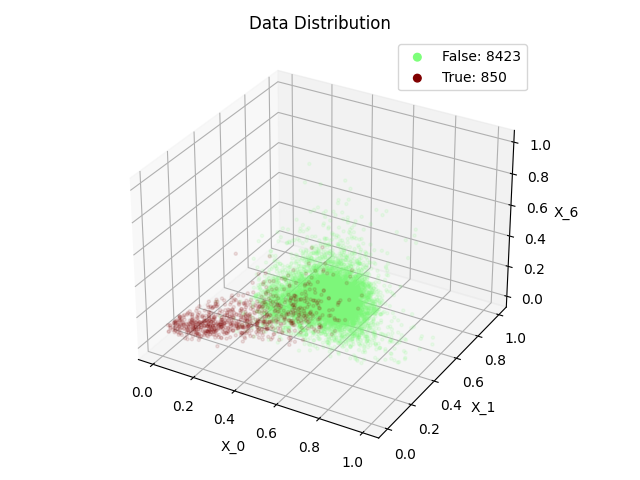

In [4]:
# Plots the normalized data with their respective classes
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, layout="tight")

visualize.cluster(ax, X_S[[0, 1, 6], :], Y_S, title="Data Distribution", axes_names=[
                  "X_0", "X_1", "X_6"], cluster_names=Y_revert, fuzzy=False)
fig.savefig(f"{image}dist.png", bbox_inches='tight')


# Sample

### PDF properties

In [5]:
# Gets PDF and entropy from different distributions
pdf_info = sample.pdf_info(I_S)


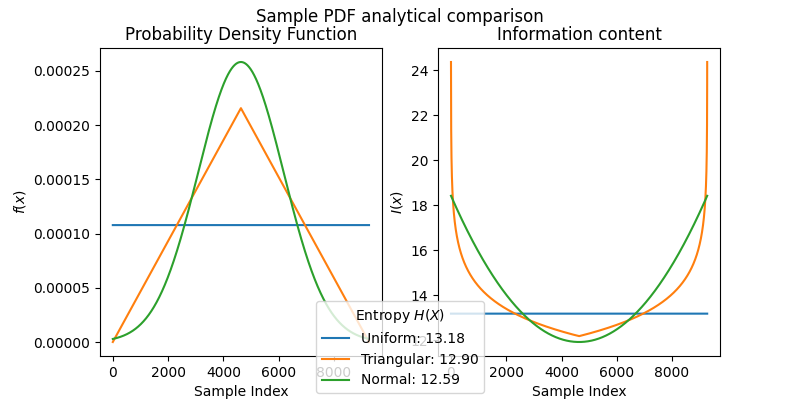

In [6]:
# Plots PDF and entropy from different distributions
fig, ax = plt.subplots(1, 2, figsize=visualize.fig_size(1, 2))
fig.suptitle("Sample PDF analytical comparison")
ax[0].set_title("Probability Density Function")
ax[1].set_title("Information content")
cluster.axis_labels(ax[0], "Sample Index", "$f(x)$")
cluster.axis_labels(ax[1], "Sample Index", "$I(x)$")

for name, info in pdf_info.items():
    ax[0].plot(I_S, info["F"], label=f"{name}: {info['H']:.2f}")
    ax[1].plot(I_S, info["I"])
fig.legend(title="Entropy $H(X)$", loc="lower center")
fig.savefig(f"{image}sample:info", bbox_inches='tight')


### Sampling data

In [7]:
# Samples the data into Train, Test, and Validation with multiple PDF
pdf_sample = sample.sample(I_S)
# Selects the uniform sampling as the one to use from now on
partition_i = pdf_sample["Uniform"]
partition = {k: (X_S[:, v], Y_S[:, v]) for k, v in partition_i.items()}
U = dict(zip(partition.keys(), [{}, {}, {}]))


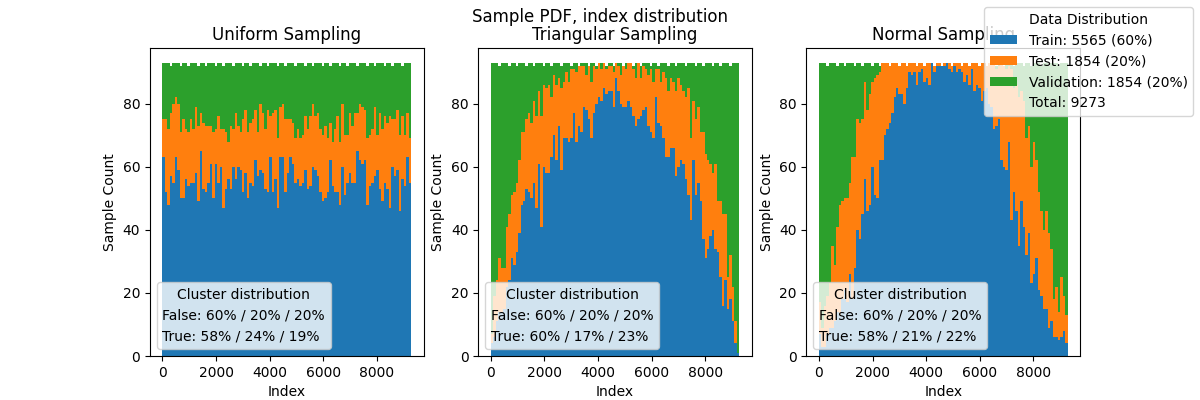

In [8]:
# Plots a histogram of the obtained sets under the selected PDFs
fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(1, 3))
fig.suptitle("Sample PDF, index distribution")
for ax_i, (pdf_name, pdf_partition) in zip(ax, pdf_sample.items()):
    ax_i.set_title(f"{pdf_name} Sampling")
    cluster.axis_labels(ax_i, 'Index', 'Sample Count')
    ax_i.hist(pdf_partition.values(), stacked=True, bins=100)
    if not classify:
        continue
    legend = []

    # Sets the legend for each plot
    for c in range(len(Y_revert)):
        legend_temp = []
        for partition_name, partition_index in pdf_partition.items():
            legend_temp.append(
                f"{np.sum(Y_S[c, partition_index])/np.sum(Y_S[c,:] == 1):.0%}")
        legend.append(f"{Y_revert[c]}: " + " / ".join(legend_temp))

    legend = ax_i.legend(legend, title="Class distribution",
                         loc="lower left", handlelength=0, handletextpad=0)
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                     for k, v in partition_i.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig(f"{image}sample:hist:index", bbox_inches='tight')


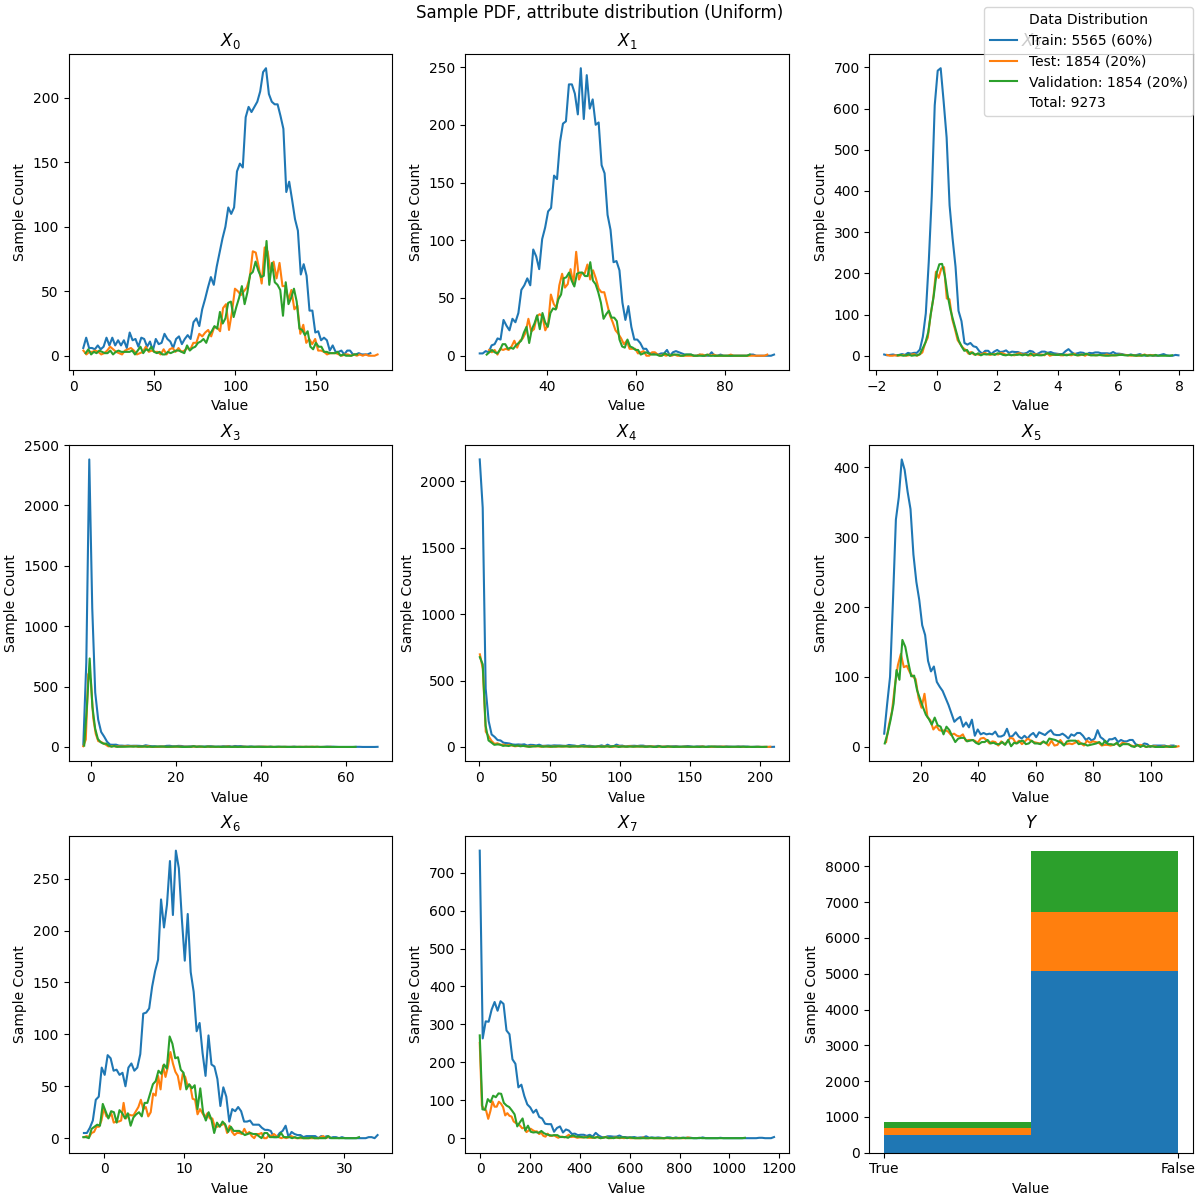

In [9]:
# Plots the final disposition of input variables for the selected PDF 
fig, ax = plt.subplots(3, 3, figsize=visualize.fig_size(
    3, 3), constrained_layout=True)
fig.suptitle(f"Sample PDF, attribute distribution (Uniform)")
for i in range(len(X_name)):
    ax_i = ax.flatten()[i]
    ax_i.set_title(f"$X_{i}$")
    cluster.axis_labels(ax_i, 'Value', 'Sample Count')
    for p in partition.values():
        yh, xh = np.histogram(X_revert(p[0])[i, :], bins=100)
        ax_i.plot(xh[:-1], yh)
i = 8
ax_i = ax.flatten()[i]
ax_i.set_title(f"$Y$")
cluster.axis_labels(ax_i, 'Value', 'Sample Count')
ax_i.hist([list(map(lambda x: Y_revert[x], np.argmax(p[1], axis=0)))
          for p in partition.values()], stacked=True, bins=2)
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                    for k, v in partition_i.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig(f"{image}sample:hist:variables", bbox_inches='tight')


# Supervised Learning

### Regression

In [ ]:
# Type of regression
K = {
    "LinReg": regression.regression["Linear"],
    "LogReg": regression.regression["Logistic"]
}


for k_name, k in K.items():
    B, _ = regression.train(*partition["Train"], k)

    for i, (p_name, (X, Y)) in enumerate(partition.items()):
        # Save output
        U[p_name][k_name], U_reg = regression.eval(X, B, k)

        # Plot predicted classes
        fig, ax = plt.subplots(1, 1, figsize=visualize.fig_size(1, 1),
                               sharey=True, layout="tight", subplot_kw={"projection": "3d"})

        visualize.cluster(ax, X[[0, 1, 6], :], U[p_name][k_name], Y)


### SVM

In [ ]:
# SVM Kernel
K = {
    "LinSVM": SVM.kernel["Linear"],
    "PolSVM": SVM.kernel["Polynomial"](2, 0),
    "RadSVM": SVM.kernel["Radial"](2)
}

C = {}
for k_name, k in K.items():
    # Solve optimization problem via gradient descent
    W, alpha, cost = SVM.train(*partition["Train"],
                               epochs=100, tolerance=0.001, eta=0.0001, K=k)
    C[k_name] = cost
    fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(1, 1),
                            sharey=True, layout="tight", subplot_kw={"projection": "3d"})
    fig.suptitle(k_name)
    for i, (p_name, (X, Y)) in enumerate(partition.items()):
        # Save output
        U[p_name][k_name] = SVM.eval(X, alpha, *partition["Train"], K=k)
        # Plot predicted classes
        visualize.cluster(ax[i], X[[0, 1, 6], :], U[p_name][k_name], Y, title=p_name)


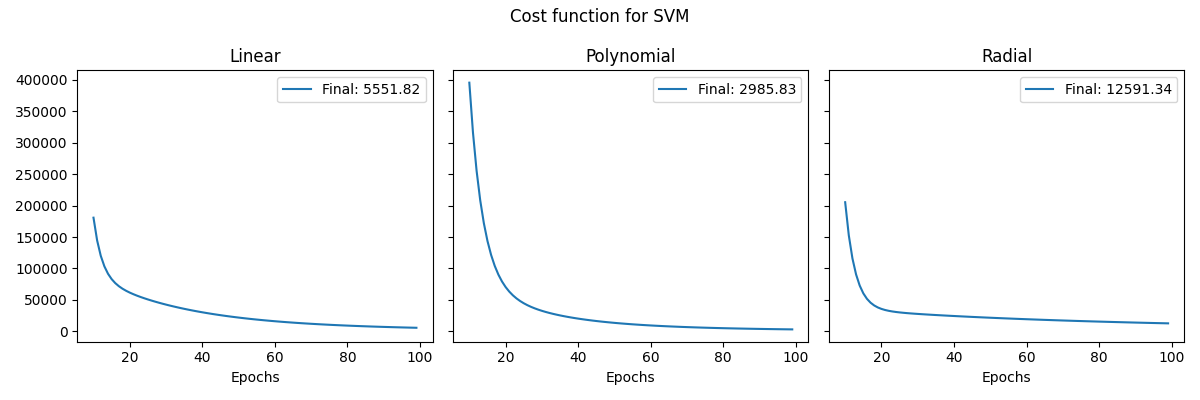

In [21]:
# Plot for the progress of the gradient descent
fig, ax = plt.subplots(1, len(K), figsize=visualize.fig_size(1, len(K)),
                       sharey=True, layout="tight")
fig.suptitle("Cost function for SVM")
for i, (k_name, cost) in enumerate(C.items()):
    ax[i].plot(range(10, len(cost)), cost[10:],
               label=f"Final: {cost[-1]:.2f}")
    ax[i].legend()
    ax[i].set_xlabel("Epochs")
    ax[i].set_title(list(SVM.kernel.keys())[i])
fig.savefig(f"{image}svn:cost.png")


### Decision Trees

In [22]:
# Auxiliary function to call tree
def one(p_name): return np.ones(partition[p_name][0].shape[1]) == 1

# Construction of the desition tree
T = d_tree.train(*partition["Train"], one("Train"))
for p_name, (X, Y) in partition.items():
    # Predicted classes via decision tree
    U_tree = d_tree.eval(partition[p_name][0], T, one(p_name))[None, :]
    U_tree = np.concatenate([U_tree, ~U_tree], axis=0)

# Depth of the final decision tree
k_tree = d_tree.depth(T)
k_tree


16

### Neural Network

In [12]:
# Array of parameters to try the construction of NN on
epochs = 5000
neurons = np.array(range(5))+1
layers = np.array(range(3))+1
eta = [0.2, 0.5, 0.9]

# Selected networks of interest, best and worst performance
nn_metric = {
    "grad:min": (np.inf, None, None),
    "grad:max": (-np.inf, None, None),
    "err:min": (np.inf, None, None),
    "err:max": (-np.inf, None, None)
}

for params in iter.product(neurons, layers, eta):
    c_neurons, c_layers, c_eta = params
    # Progress bar
    print(params, end="\r")
    # Trains the NN, hides progress bar of training
    with HiddenPrints():
        W, B, delta_nn, E_nn = nn.train(partition["Train"],
                                        hidden=[c_neurons] * c_layers, classify=classify, test_set=partition,
                                        epochs=epochs, tolerance=0.000001, eta=c_eta)
    # Calculates gradient length and total error
    grad = np.sum(delta_nn[-1])
    err = np.sum([e[-1] for e in E_nn.values()])

    # Updates networks of interest
    if grad < nn_metric["grad:min"][0]:
        nn_metric["grad:min"] = (grad, params, (W, B, delta_nn, E_nn))
    if grad > nn_metric["grad:max"][0]:
        nn_metric["grad:max"] = (grad, params, (W, B, delta_nn, E_nn))
    if err < nn_metric["err:min"][0]:
        nn_metric["err:min"] = (err, params, (W, B, delta_nn, E_nn))
    if err > nn_metric["err:max"][0]:
        nn_metric["err:max"] = (err, params, (W, B, delta_nn, E_nn))


In [13]:
# Evaluates all sample sets on the best networks and saves results
for p_name, (X, Y) in partition.items():
    grad, params, (W, B, delta_nn, E_nn) = nn_metric["err:min"]
    U[p_name]["NNErr"], _ = nn.eval(X, W, B, classify=True)
    grad, params, (W, B, delta_nn, E_nn) = nn_metric["grad:min"]
    U[p_name]["NNGrad"], _ = nn.eval(X, W, B, classify=True)


In [ ]:
# Epochs to skip when plotting
skip = 10

# Titles for the networks of interest
nn_title = {
    "grad:min": "Min Gradient",
    "grad:max": "Max Gradient",
    "err:min": "Min Error",
    "err:max": "Max Error"
}

# Cycles through the selected networks of interest
for name, (value, (neurons, layers, eta), ((W, B, delta_nn, E_nn))) in nn_metric.items():
    # Plots average gradient length per layer
    fig, ax = plt.subplots(
        1, 2, figsize=visualize.fig_size(1, 2), layout="tight")
    fig.suptitle(f"{nn_title[name]}: {neurons, layers, eta}")
    ax[0].set_title("Gradients per epoch")
    ax[0].plot(range(skip, len(delta_nn)), delta_nn[skip:],
               label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
    ax[0].plot([], [], label=f"Total: {np.sum(delta_nn[-1]):.2e}")
    legend = ax[0].legend(title="Layer", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[0], "Epoch",
                        "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

    # Plots average error per sample set
    ax[1].set_title("Error per epoch")
    for p_name in E_nn.keys():
        ax[1].plot(range(skip, len(E_nn[p_name])), E_nn[p_name][skip:],
                   label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
    ax[1].plot(
        [], [], label=f"Total: {np.sum([e[-1] for e in E_nn.values()]):.2e}")
    legend = ax[1].legend(title="Partition", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[1], "Epoch",
                        "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")
    fig.savefig(f"{image}nn:{name}.png", bbox_inches='tight')


# Unsupervised Learning

### Mountain Clustering

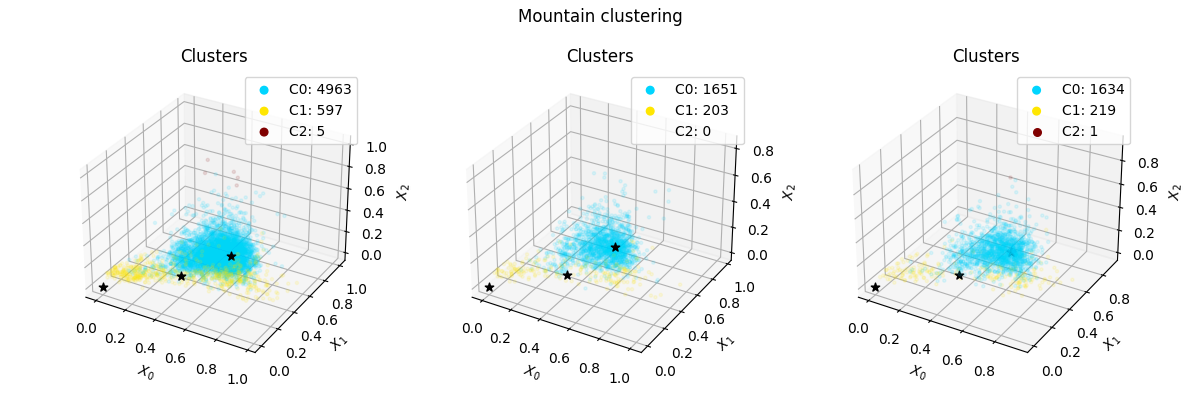

In [26]:
# Selects grid size for Clustering
n = int(10**(5/X_S.shape[0]))

# Runs mountain clustering with selected n
C = mountain.train(partition["Train"][0], 1, 1, n=n, epsilon=50)

# Plot found clusters
fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(
    1, 3), subplot_kw={"projection": "3d"}, layout="tight")
fig.suptitle("Mountain clustering")

for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["MtnCluster"] = k_means.eval(X, C)
    visualize.cluster(ax[i], X[[0, 1, 6], :], U[p_name]["MtnCluster"], C=C)

fig.savefig(f"{image}mountain.png")
# Saves number of clusters
k_mountain = C.shape[1]


### Substractive Clustering

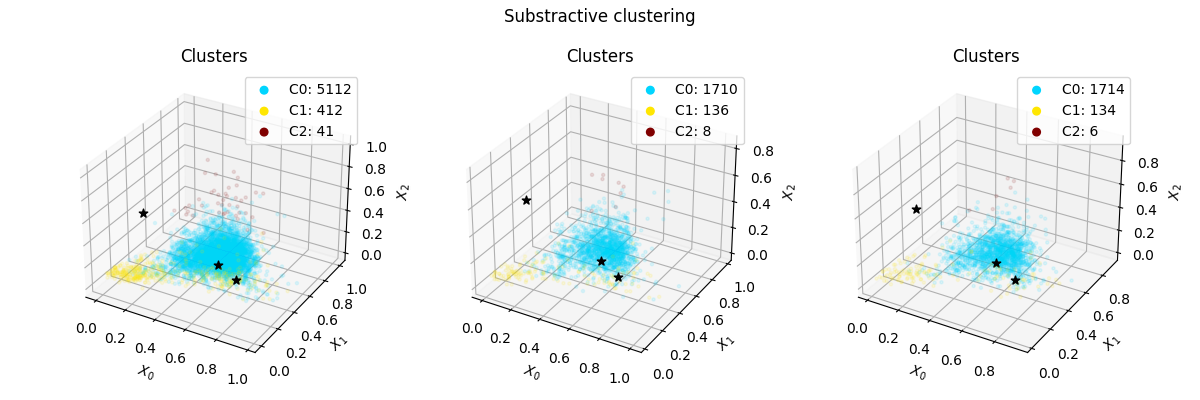

In [27]:
# Runs substractive clustering
C = mountain.train(partition["Train"][0], 1, 1, 50, substractive=True)

# Plot found clusters
fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(
    1, 3), subplot_kw={"projection": "3d"}, layout="tight")
fig.suptitle("Substractive clustering")
for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["SubCluster"] = k_means.eval(X, C)
    visualize.cluster(ax[i], X[[0, 1, 6], :], U[p_name]["SubCluster"], C=C)

fig.savefig(f"{image}substractive.png")
# Saves number of clusters
k_subs = int(C.shape[1])


### K-Means

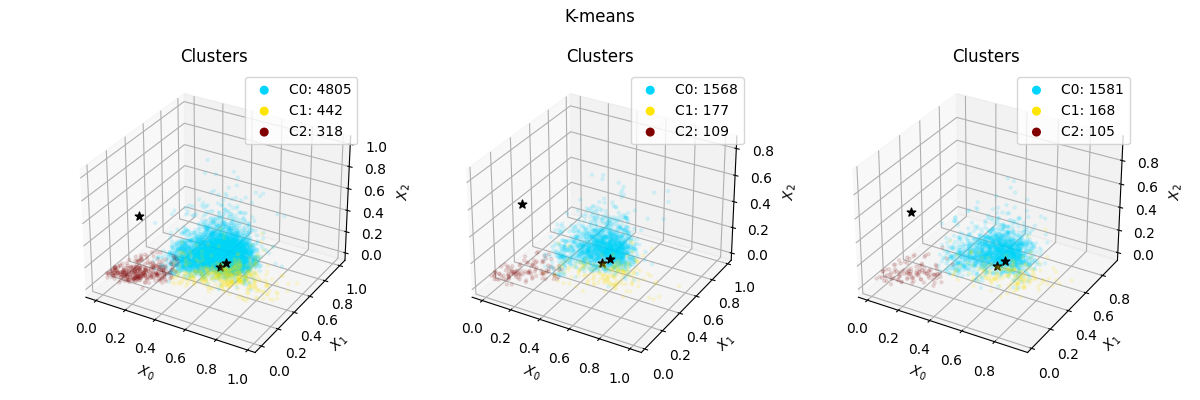

In [28]:
# Runs k-means with the k found by mountain clustering
_, C = k_means.train(partition["Train"][0], k_mountain, 0.00001)

# Plot found clusters
fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(
    1, 3), subplot_kw={"projection": "3d"}, layout="tight")
fig.suptitle("K-means")
for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["Kmeans"] = k_means.eval(X, C)
    visualize.cluster(ax[i], X[[0, 1, 6], :], U[p_name]["Kmeans"], C=C)

fig.savefig(f"{image}kmeans.png")


### Fuzzy C-means

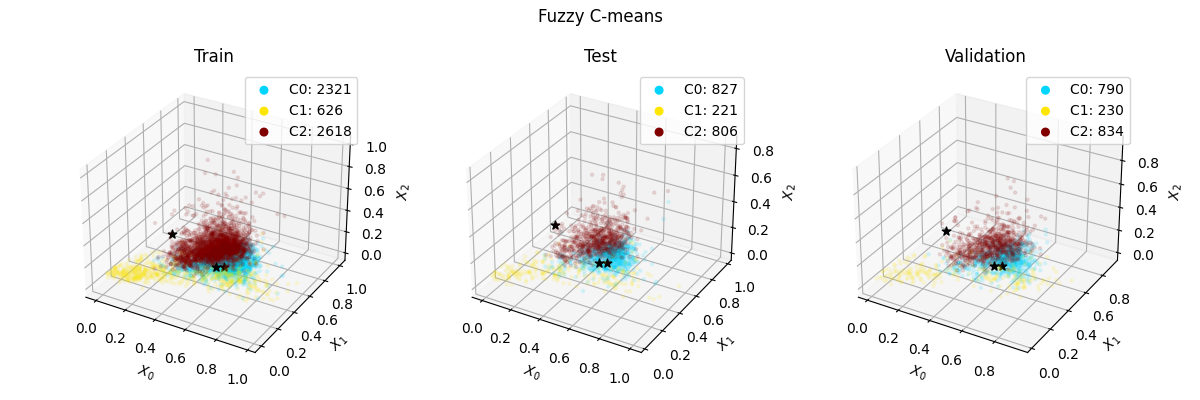

In [29]:
# Runs Fuzzy C-Means with C found by substractive clustering
m = 2
_, C = fuzzy_c_means.train(k_subs, partition["Train"][0], m, 0.002)

# Plot found clusters
fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(
    1, 3), subplot_kw={"projection": "3d"}, layout="tight")
fig.suptitle("Fuzzy C-means")
for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["FuzzyC"] = fuzzy_c_means.eval(X, C, m)
    visualize.cluster(ax[i], X[[0, 1, 6], :], U[p_name]
                      ["FuzzyC"], title=p_name, C=C)
fig.savefig(f"{image}fuzzycmeans.png")


In [30]:
# Creates comparative table for all methods
for p_name, (X, Y) in partition.items():
    U_table = index.eval(U[p_name], Y)
    U_table[0, 0] = ""
    for i in range(1, U_table.shape[0]):
        for j in range(1, U_table.shape[1]):
            U_table[i, j] = f"{U_table[i, j]:.2f}"
    print(U_table)
    np.savetxt(f"{table}index:{p_name.lower()}.csv",
               U_table, delimiter=",", fmt='%s')


### Hybrid

##### Autoencoder

In [9]:
p = {
    "Train": (partition["Train"][0], partition["Train"][0]),
    "Test": (partition["Test"][0], partition["Test"][0]),
    "Validation": (partition["Validation"][0], partition["Validation"][0])
}
skip = 100
epochs = 5000
delta_nn_all = [None]*8
E_nn_all = [None]*8
W_all = [None]*8
B_all = [None]*8

delta_nn_code = [None]*8
E_nn_code = [None]*8
W_nn_code = [None]*8
B_nn_code = [None]*8
for i in range(8,0,-1):
    print(f"{i} neurons")
    W_code, B_code, delta_code, E_code = nn.autoencoder(p["Train"][0], i, epochs, p)

    p2 = {p_name: (nn.code(p_[0], W_code, B_code), p_[1]) 
        for p_name, p_ in partition.items()}
    
    W_all[i-1] = W_code
    B_all[i-1] = B_code
    delta_nn_all[i-1] = np.sum(delta_code, axis=1)
    E_nn_all[i-1] = E_code["Test"]

    W, B, delta, E = nn.train(p2["Train"], epochs, [3]*4, 0.9, 0, classify=True, test_set=p2)
    W_nn_code[i-1] = W
    B_nn_code[i-1] = B
    delta_nn_code[i-1] = np.sum(delta, axis=1)
    E_nn_code[i-1] = E["Test"]

8 neurons
7 neurons (100%)
6 neurons (100%)
5 neurons (100%)
4 neurons (100%)
3 neurons (100%)
2 neurons (100%)
1 neurons (100%)


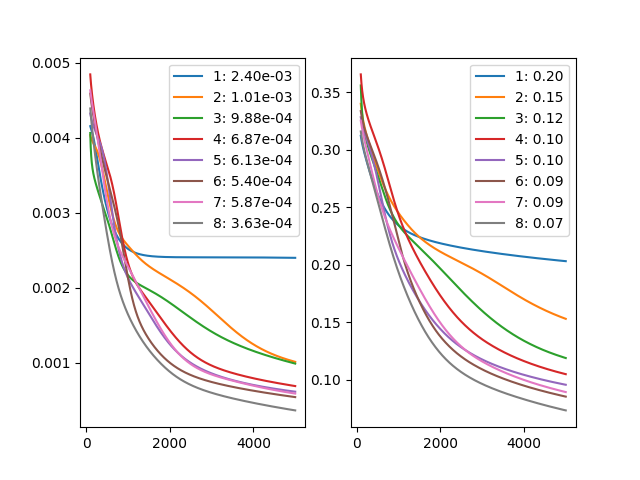

In [10]:
fig, ax = plt.subplots(1,2)
for i, (d, e) in enumerate(zip(delta_nn_all, E_nn_all)):
    ax[0].plot(range(skip,epochs), d[skip:], label=f"{i+1}: {d[-1]:.2e}")
    ax[1].plot(range(skip,epochs), e[skip:], label=f"{i+1}: {e[-1]:.2f}")
ax[0].legend()
ax[1].legend()



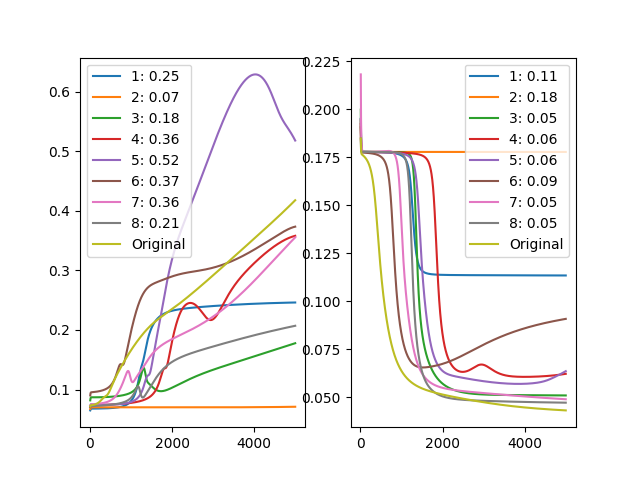

In [16]:
fig, ax = plt.subplots(1,2)
for i, (d, e) in enumerate(zip(delta_nn_code, E_nn_code)):
    ax[0].plot(range(skip,epochs), d[skip:], label=f"{i+1}: {d[-1]:.2f}")
    ax[1].plot(range(skip,epochs), e[skip:], label=f"{i+1}: {e[-1]:.2f}")
_, _, (W, B, delta_last, err_last) = nn_metric["err:min"]
ax[0].plot(range(skip,epochs), np.sum(delta_last, axis=1)[skip:], label=f"Original")
ax[1].plot(range(skip,epochs), err_last["Test"][skip:], label=f"Original")

ax[0].legend()
ax[1].legend()